In [9]:
import jcopdl, luwiji

jcopdl.__version__, luwiji.__version__

('1.1.9', '1.2.1')

In [10]:
import torchvision

In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [12]:
import torch
from torch import nn, optim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [13]:
print(torch.version.cuda)

None


In [14]:
print(torch.__version__)

2.0.1


# import Data

In [15]:
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


,missing_value,%
Pregnancies,0,0.00
Glucose,5,0.65
BloodPressure,35,4.56
SkinThickness,227,29.56
Insulin,374,48.70
BMI,11,1.43
DiabetesPedigreeFunction,0,0.00
Age,0,0.00
Outcome,0,0.00


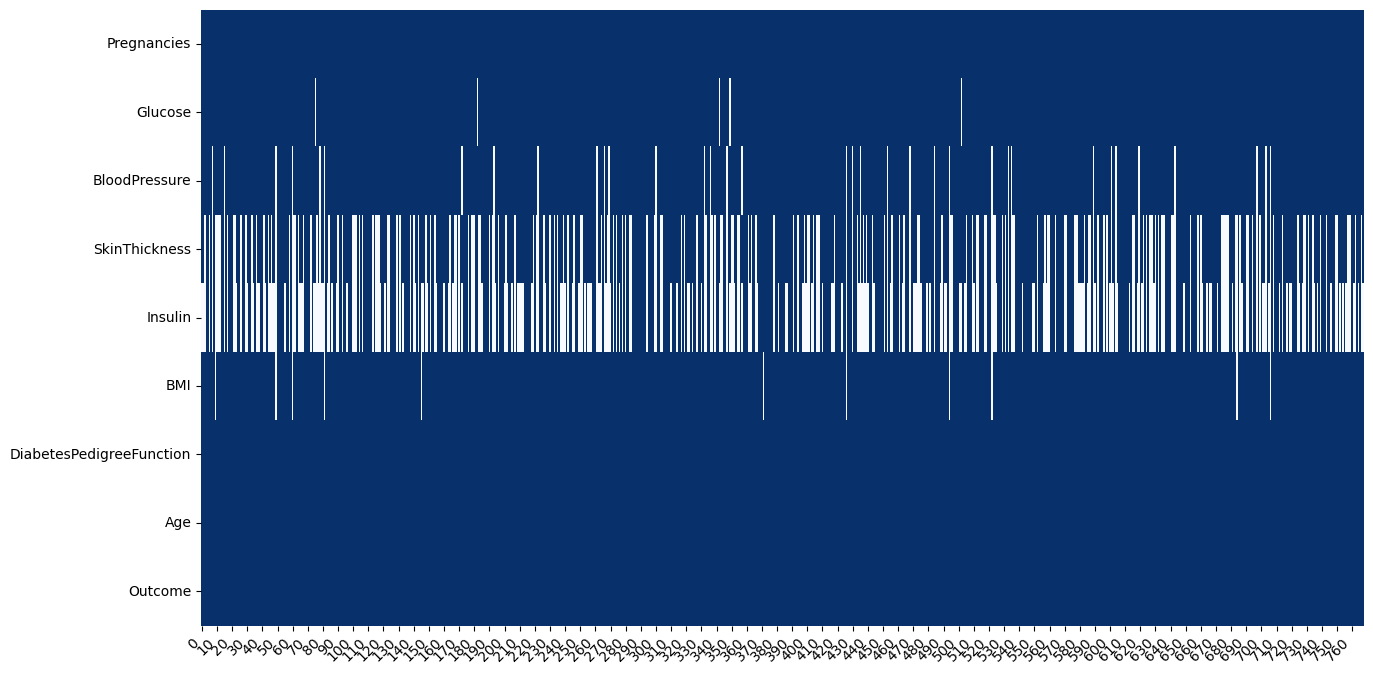

In [16]:
plot_missing_value(df, return_df=True)

In [17]:
df.Outcome.value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [18]:
df.drop(columns="Insulin", inplace=True)

# Dataset Splitting

In [19]:
X = df.drop(columns="Outcome")
y = df.Outcome.values # karena mau pakai pytorch, pytorch tidak bisa interaksi dengan pandas maka itu dijadikan numpy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

# Preprocess Data

In [20]:
type(y_train)

numpy.ndarray

In [21]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
353,1,90.0,62.0,12.0,27.2,0.580,24
711,5,126.0,78.0,27.0,29.6,0.439,40
373,2,105.0,58.0,40.0,34.9,0.225,25
46,1,146.0,56.0,NaN,29.7,0.564,29
682,0,95.0,64.0,39.0,44.6,0.366,22


In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
     ])

In [23]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [24]:
X_train

array([[1.00e+00, 9.00e+01, 6.20e+01, ..., 2.72e+01, 5.80e-01, 2.40e+01],
       [5.00e+00, 1.26e+02, 7.80e+01, ..., 2.96e+01, 4.39e-01, 4.00e+01],
       [2.00e+00, 1.05e+02, 5.80e+01, ..., 3.49e+01, 2.25e-01, 2.50e+01],
       ...,
       [1.00e+00, 9.70e+01, 7.00e+01, ..., 3.81e+01, 2.18e-01, 3.00e+01],
       [1.00e+01, 1.11e+02, 7.00e+01, ..., 2.75e+01, 1.41e-01, 4.00e+01],
       [4.00e+00, 1.44e+02, 5.80e+01, ..., 2.95e+01, 2.87e-01, 3.70e+01]])

# Dataset & Dataloader

In [25]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device) #kolom target adalah 0 sama 1 klasifikasi maka itu harus integer
y_test = torch.LongTensor(y_test).to(device)

# X_train = torch.FloatTensor(X_train)
# X_test = torch.FloatTensor(X_test)
# y_train = torch.LongTensor(y_train)
# y_test = torch.LongTensor(y_test)
# # Kolom target multiclass 0 1 berarti harus integer/LongTensor kecuali sigmoid, binary classification boleh pakai FloatTensor

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [27]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True) 

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

# Training Preparation -> MCO

In [28]:
y_train

tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,

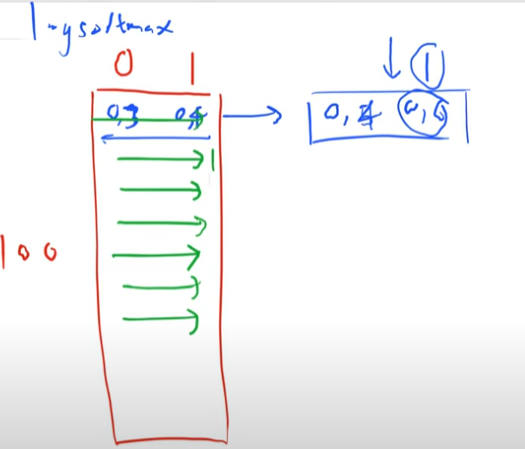

In [29]:
# model = nn.Sequential(
#     nn.Linear(7, 16),
#     nn.ReLU(),
#     nn.Linear(16, 8),
#     nn.ReLU(),
#     nn.Linear(8, 4),
#     nn.ReLU(),
#     nn.Linear(4, 2),
#     nn.LogSoftmax(1), #multiclass classification
# )

model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.LogSoftmax(1), #multiclass classification -> 1 maksudnya dimensi satu
)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

- biasanya CNN, RNN, ANN - nn.logsoftmax(1) -> dimensi satu

- kalau audio bisa dimensi dua

nn.CrossEntropyLoss()
nn.NLLLoss()

#### mana yang lebih baik?
- Cross entropy loss = komputasi lebih stabil
- NLLLoss = prediksinya lebih mudah

# Training

In [30]:
epochs = 1000
train_cost, test_cost = [], []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in trainloader:
        output = model(feature) # feed forward
        loss = criterion(output, target)
        loss.backward() #backprop
        
        optimizer.step() #update weight
        optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))
    
    # data test tidak ada backprop dan update weight
    with torch.no_grad(): # agar tidak hitung gradient untuk data test karena kalau dihitung jadi data leakage
        model.eval() # untuk evaluasi
        cost = 0
        for feature, target in testloader:
            output = model(feature) # feed forward -> prediksi
            loss = criterion(output, target) # kesalahan atau loss di prediksi di data test
            
            # Reporting 
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_set))
            
    print(f"\rEpoch: {i+1:4}/{epochs:4} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}", end=" ")

Epoch: 1000/1000 | train_cost: 0.3979 | test_cost: 0.5617 

# Cost History

In [33]:
import matplotlib.pyplot as plt

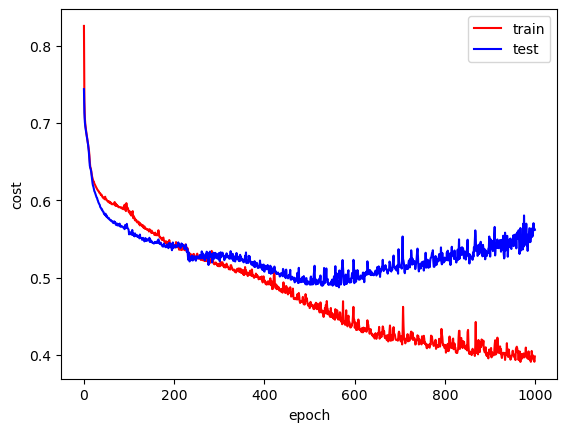

In [34]:
plt.plot(train_cost, 'r-', label='train')
plt.plot(test_cost, 'b-', label='test')
plt.xlabel("epoch");plt.ylabel("cost");plt.legend();

## Predict 

In [35]:
X_test

tensor([[  7.0000, 159.0000,  64.0000,  ...,  27.4000,   0.2940,  40.0000],
        [ 10.0000,  68.0000, 106.0000,  ...,  35.5000,   0.2850,  47.0000],
        [  2.0000, 122.0000,  76.0000,  ...,  35.9000,   0.4830,  26.0000],
        ...,
        [  2.0000,  82.0000,  52.0000,  ...,  28.5000,   1.6990,  25.0000],
        [  4.0000, 184.0000,  78.0000,  ...,  37.0000,   0.2640,  31.0000],
        [  1.0000,  71.0000,  78.0000,  ...,  33.2000,   0.4220,  21.0000]])

In [36]:
with torch.no_grad():
    model.eval()
    output = model(X_test) # output ini logsoftmax

In [37]:
output

tensor([[-9.9931e-01, -4.5908e-01],
        [-6.9951e-04, -7.2654e+00],
        [-5.6364e-01, -8.4195e-01],
        [-2.4632e-01, -1.5217e+00],
        [-2.7259e-04, -8.2075e+00],
        [-2.8204e-01, -1.4034e+00],
        [-5.6215e-01, -8.4393e-01],
        [-2.9820e+00, -5.2021e-02],
        [-9.5296e-02, -2.3980e+00],
        [-2.7677e+00, -6.4867e-02],
        [-1.9575e-01, -1.7272e+00],
        [-5.6266e-01, -8.4326e-01],
        [-4.2143e-02, -3.1877e+00],
        [-1.2067e-01, -2.1744e+00],
        [-2.3116e-01, -1.5780e+00],
        [-7.0285e-01, -6.8354e-01],
        [-7.7491e-01, -6.1757e-01],
        [-7.0728e-02, -2.6841e+00],
        [-1.7207e+00, -1.9715e-01],
        [-3.9934e-01, -1.1110e+00],
        [-9.9245e-02, -2.3594e+00],
        [-1.9956e+00, -1.4610e-01],
        [-4.3415e-01, -1.0436e+00],
        [-5.7267e+00, -3.2630e-03],
        [-1.3730e+00, -2.9215e-01],
        [-3.4571e-06, -1.2579e+01],
        [-1.2740e+00, -3.2812e-01],
        [-4.9303e-02, -3.034

yang kiri tidak diabetes, yang kanan diabetes

In [38]:
torch.exp(output)

tensor([[3.6813e-01, 6.3187e-01],
        [9.9930e-01, 6.9930e-04],
        [5.6913e-01, 4.3087e-01],
        [7.8167e-01, 2.1833e-01],
        [9.9973e-01, 2.7260e-04],
        [7.5424e-01, 2.4576e-01],
        [5.6998e-01, 4.3002e-01],
        [5.0691e-02, 9.4931e-01],
        [9.0910e-01, 9.0897e-02],
        [6.2807e-02, 9.3719e-01],
        [8.2222e-01, 1.7778e-01],
        [5.6969e-01, 4.3031e-01],
        [9.5873e-01, 4.1268e-02],
        [8.8633e-01, 1.1367e-01],
        [7.9361e-01, 2.0639e-01],
        [4.9517e-01, 5.0483e-01],
        [4.6075e-01, 5.3925e-01],
        [9.3172e-01, 6.8285e-02],
        [1.7894e-01, 8.2106e-01],
        [6.7076e-01, 3.2924e-01],
        [9.0552e-01, 9.4479e-02],
        [1.3593e-01, 8.6407e-01],
        [6.4781e-01, 3.5219e-01],
        [3.2577e-03, 9.9674e-01],
        [2.5335e-01, 7.4665e-01],
        [1.0000e+00, 3.4419e-06],
        [2.7972e-01, 7.2028e-01],
        [9.5189e-01, 4.8107e-02],
        [7.0097e-01, 2.9903e-01],
        [9.492

In [39]:
output.argmax(1)

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [40]:
#logsoftmax
pred = output.argmax(1) # ambil index ke 0 atau ke 1
pred

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

## Accuracy 

In [41]:
y_test

tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [42]:
(y_test == pred).to(torch.float32).mean()

tensor(0.7013)

In [43]:
acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.7013)

In [44]:
y_test == pred

tensor([False,  True,  True, False,  True,  True, False,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True, False,  True,
         True,  True, False,  True, False,  True,  True,  True, False,  True,
         True,  True, False, False, False, False, False,  True,  True, False,
        False,  True,  True, False,  True,  True, False,  True,  True, False,
        False,  True, False,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True, False, False, False,  True,  True,  True,  True,  True,
        False, False, False, False, False,  True,  True,  True, 

#  Mengurangi Overfit dengan Dropout

Sebelumnya pakai regularization
- lasso
- ridge
- l1
- l2

pruning

In [45]:
from luwiji.neural_network import illustration

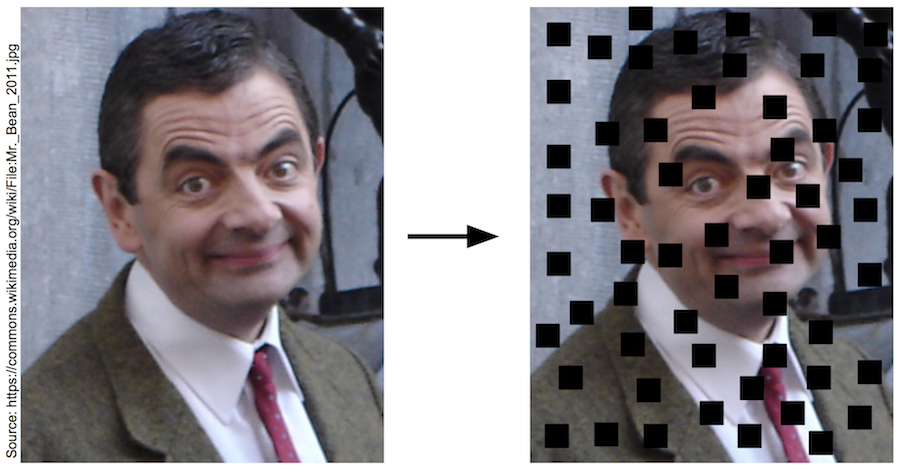

In [46]:
illustration.dropout_idea

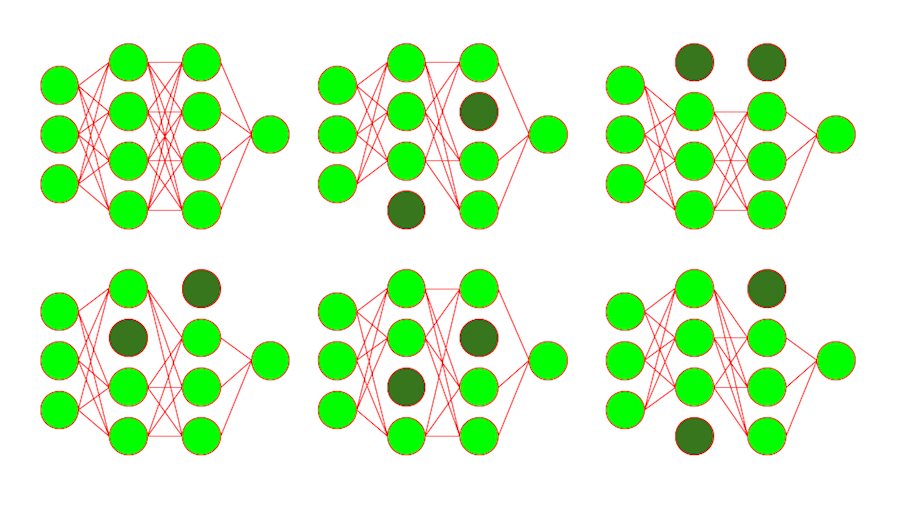

In [47]:
illustration.dropout

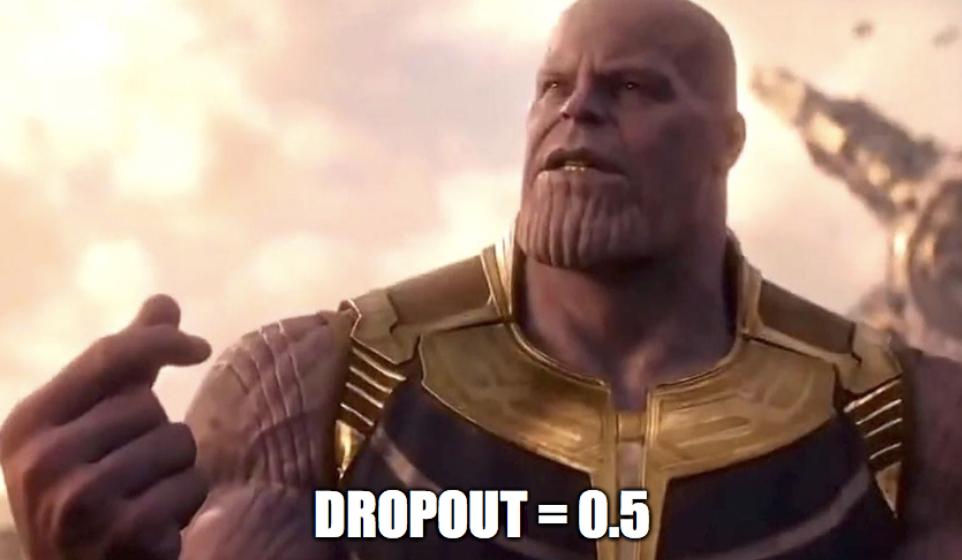

In [48]:
illustration.dropout_balance

bias = error

jika bias bertambah variance berkurang

menurunkan overfit

### MCO 

In [49]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4, 2),
    nn.LogSoftmax(1), #multiclass classification
).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

catatan *Dropout hanya ada di hidden layer 

### Training 

In [50]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [51]:
epochs = 1000
train_cost, test_cost = [], []
train_acc, test_acc = [], []
for i in range(epochs):
    cost, acc = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_acc.append(acc)
    with torch.no_grad(): # supaya menghemat memori
        cost, acc = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_acc.append(acc)
        
    print(f'\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f} | '
         f"train_acc: {train_acc[-1]:4f} | test_acc: {test_acc[-1]:.4f}",end=' ')

Epoch: 1000/1000 | train_cost: 0.5541 | test_cost: 0.6883 | train_acc: 0.745928 | test_acc: 0.6494 

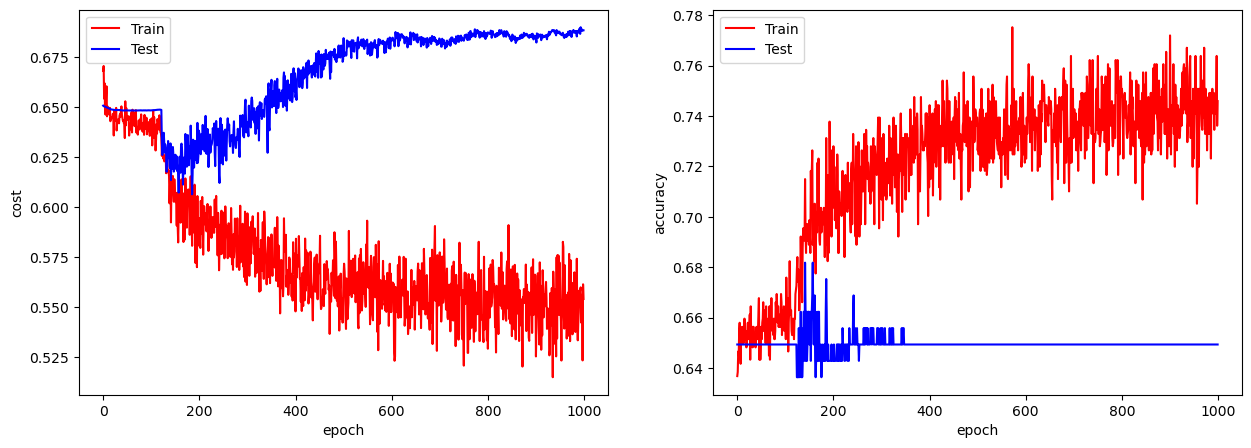

In [52]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(train_cost, "r", label="Train")
plt.plot(test_cost, "b-", label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.plot(train_acc, "r-", label="Train")
plt.plot(test_acc, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend();

bisa juga jika overfit dikurangi neuronnya 8, 4, 4

## Save ~~Model~~ Weights

In [5]:
import os # untuk mengakses komputer kita

In [6]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'data.zip',
 'model',
 'Part 1 - Neural Network.ipynb',
 'Part 2 - (Opsional) Neural Network with Scikit-learn.ipynb',
 'Part 3 - Pytorch Introduction.ipynb',
 'Part 4 - Feedforward, Backpropagation, dan Minibatch.ipynb',
 'Part 5 - PyTorch Workflow.ipynb',
 'Part 6 - Neural Network with PyTorch.ipynb',
 'Part 7 - Python Class and Object Oriented Programming.ipynb',
 'Part 8 - Callback and more ML engineering.ipynb',
 'Part 9 - Update your snippets.ipynb',
 'Untitled.ipynb',
 '__MACOSX']

In [53]:
import os # untuk mengakses komputer kita
os.makedirs("model", exist_ok=True) # jika folder sudah ada tidak usah buat folder baru -> exist_ok = True

In [54]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0745, -0.0088,  0.2298,  0.0144, -0.3829, -0.9308, -0.2355],
                      [ 0.3791,  0.1667,  0.0023,  0.0140,  0.3002,  0.7318,  0.0331],
                      [-0.2430,  0.0215, -0.2334,  0.1054, -0.1178,  0.1048, -0.0712],
                      [ 0.2836, -0.2027, -0.2039, -0.2040,  0.3076,  0.1140,  0.3290],
                      [-0.2822, -0.3392, -0.2675, -0.2300,  0.1385,  0.1224,  0.2841],
                      [-0.2158, -0.2760,  0.1302, -0.1895,  0.1609, -0.1163,  0.1366],
                      [ 0.3500, -0.1900,  0.1975, -0.0346, -0.2198, -0.7243,  0.2631],
                      [-0.2721, -0.1797,  0.3169, -0.0916, -0.1470, -0.3105, -0.2025],
                      [ 0.0854, -0.0451, -0.2482,  0.0080, -0.2336, -0.2901, -0.1883],
                      [-0.3265, -0.2734,  0.2721,  0.0054,  0.0498, -0.3799, -0.2842],
                      [-0.1138,  0.0535, -0.3009, -0.1473, -0.2047,  0.0009, -0.1272],
                 

In [55]:
torch.save(model.state_dict(), "model/weights.pth")

In [56]:
log = {
    "train_cost": train_cost,
    "test_cost": test_cost,
    "train_acc": train_acc,
    "test_acc": test_acc
}
torch.save(log, "model/logs.pth") # plot logging

## Load model

In [57]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(4, 2),
    nn.LogSoftmax(1), #multiclass classification
)

In [59]:
model.state_dict() # weight di timpa dengan yang sudah ditrain

OrderedDict([('0.weight',
              tensor([[-0.0929, -0.3718,  0.1665, -0.0287,  0.2995,  0.0398, -0.0969],
                      [ 0.0303, -0.2138,  0.1689,  0.2479, -0.0964, -0.3636, -0.1977],
                      [-0.0717,  0.3093, -0.0183,  0.2394, -0.0558, -0.0487,  0.1999],
                      [-0.3365, -0.0793,  0.3508,  0.0948, -0.2208,  0.2791,  0.1324],
                      [-0.3128,  0.1534, -0.3403,  0.0171, -0.1860, -0.2831, -0.2179],
                      [ 0.0186,  0.2920,  0.2228, -0.1287, -0.3778, -0.0422,  0.1482],
                      [-0.0286,  0.3609, -0.2478, -0.3750,  0.0578, -0.0906,  0.0365],
                      [-0.0069,  0.1324,  0.1955,  0.2724, -0.1184, -0.1630, -0.3235],
                      [ 0.1169, -0.0755,  0.3435,  0.1483,  0.1861,  0.2919, -0.0289],
                      [-0.1894,  0.3219, -0.1059,  0.3618, -0.3164, -0.3159,  0.2288],
                      [ 0.1411,  0.2028, -0.1845, -0.1652,  0.1816, -0.0043, -0.3640],
                 

In [60]:
weights = torch.load("model/weights.pth", map_location="cpu") # map location load ke CPU dulu

In [62]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1) # argmax mencari probability yang paling tinggi
    acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.6494)

In [63]:
model.load_state_dict(weights)
model = model.to(device)

In [65]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0745, -0.0088,  0.2298,  0.0144, -0.3829, -0.9308, -0.2355],
                      [ 0.3791,  0.1667,  0.0023,  0.0140,  0.3002,  0.7318,  0.0331],
                      [-0.2430,  0.0215, -0.2334,  0.1054, -0.1178,  0.1048, -0.0712],
                      [ 0.2836, -0.2027, -0.2039, -0.2040,  0.3076,  0.1140,  0.3290],
                      [-0.2822, -0.3392, -0.2675, -0.2300,  0.1385,  0.1224,  0.2841],
                      [-0.2158, -0.2760,  0.1302, -0.1895,  0.1609, -0.1163,  0.1366],
                      [ 0.3500, -0.1900,  0.1975, -0.0346, -0.2198, -0.7243,  0.2631],
                      [-0.2721, -0.1797,  0.3169, -0.0916, -0.1470, -0.3105, -0.2025],
                      [ 0.0854, -0.0451, -0.2482,  0.0080, -0.2336, -0.2901, -0.1883],
                      [-0.3265, -0.2734,  0.2721,  0.0054,  0.0498, -0.3799, -0.2842],
                      [-0.1138,  0.0535, -0.3009, -0.1473, -0.2047,  0.0009, -0.1272],
                 

In [64]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1)
    acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.6494)

AdamW = regularization L2